2.2 The Marcenko-Pastur Theorem

Marcenko-Pastur 이론에 따르면 큰 차원의 무작위 행렬에서, 표본 공분산 행렬의 고윳값분포가 특정한 확률밀도함수 (Marcenko-Pastur PDF를 따름을 보장)
따라서 KDE로 추정한 emiprical eigenvalue 분포와 MP PDF가 거의 일치.

Estimated bandwidth for KDE: 0.0126


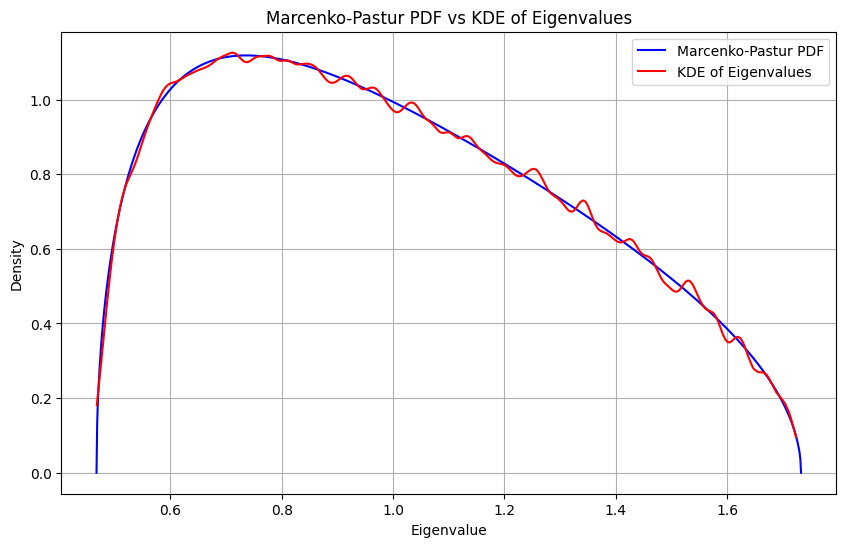

In [48]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity

def get_marcenko_pastur_pdf(var:float, q:float, sample_size:int) -> pd.Series:
    '''
    Calculate the Marcenko-Pastur probability density function (PDF) for a given variance,
    ratio of T/N (q), and sample size.
    '''
    min_eigen_value=var*(1-(1/q)**0.5)**2
    max_eigen_value=var*(1+(1/q)**0.5)**2
    eigen_value_range = np.linspace(min_eigen_value, max_eigen_value, sample_size)
    pdf=q/(2*np.pi*var*eigen_value_range)* np.sqrt((max_eigen_value-eigen_value_range)*(eigen_value_range-min_eigen_value))
    pdf=pd.Series(pdf, index=eigen_value_range)
    return pdf  

def get_kde(obs:np.ndarray, b_width:float=0.25, kernel:str='gaussian', x=None) -> pd.Series:
    if len(obs.shape)==1: 
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=b_width).fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1, 1)
    if len(x.shape)==1:
        x = x.reshape(-1, 1)
    log_p=kde.score_samples(x)
    pdf=pd.Series(np.exp(log_p), index=x.flatten())
    return pdf

# testing the marcenko-pastur theorem

def get_pca(corr:pd.DataFrame):
    e_val, e_vec = np.linalg.eig(corr)
    indices = np.argsort(e_val)[::-1]
    e_val = e_val[indices]
    e_vec = e_vec[:, indices]
    e_val=np.diagflat(e_val)
    return e_val, e_vec

x=np.random.normal(size=(10000,1000))
e_val, e_vec = get_pca(np.corrcoef(x, rowvar=False))
sample_size = 1000
var=1
pdf1= get_marcenko_pastur_pdf(var=var, q=x.shape[0]/x.shape[1], sample_size=sample_size)
min_eigen_value=var*(1-(1/(x.shape[0]/x.shape[1]))**0.5)**2
max_eigen_value=var*(1+(1/(x.shape[0]/x.shape[1]))**0.5)**2
estimated_b_width = (max_eigen_value - min_eigen_value) / sample_size*10
print(f"Estimated bandwidth for KDE: {estimated_b_width:.4f}")
pdf2 = get_kde(np.diag(e_val), b_width=estimated_b_width)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(pdf1.index, pdf1, label='Marcenko-Pastur PDF', color='blue')
plt.plot(pdf2.index, pdf2, label='KDE of Eigenvalues', color='red')
plt.title('Marcenko-Pastur PDF vs KDE of Eigenvalues')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()



2.3 Random Matrix with Signal

In [ ]:
def get_random_cov_matrix(n_cols:int, n_rank:int) -> np.ndarray:
    '''Generate a random covariance matrix with a specified rank.
    '''
    w=np.random.normal(size=(n_cols, n_rank))
    cov_matrix = np.dot(w, w.T)
    cov_matrix+=np.diag(np.random.uniform(size=n_cols))
    return cov_matrix

def get_corr_matrix(cov_matrix:np.ndarray) -> np.ndarray:
    '''
    Convert a covariance matrix to a correlation matrix.
    '''
    std_dev = np.sqrt(np.diag(cov_matrix))
    corr_matrix = cov_matrix / np.outer(std_dev, std_dev)
    corr_matrix[corr_matrix > 1] = 1
    corr_matrix[corr_matrix < -1] = -1
    return corr_matrix

alpha, n_cols, n_rank, q=0.995, 1000, 100, 10
cov=np.cov(np.random.normal(size=(n_cols*q, n_cols)), rowvar=False)
cov=alpha * cov + (1-alpha) * get_random_cov_matrix(n_cols, n_rank) # signal + noise
corr_matrix = get_corr_matrix(cov)
e_val, e_vec = get_pca(corr_matrix)

2.4 Fitting The Marcenko-Pastur PDF

1. MP 분포를 활용한 noise 추정

    Marcenko–Pastur(MP) 분포로 noise eigenvalue의 분포를 추정합니다.MP upper bound를 초과하는 eigenvalue들은 noise로 설명되지 않으므로, signal 요인에 의한 분산으로 해석합니다.

2. Correlation matrix 기반 정규화
    covariance matrix를 correlation matrix로 변환하여 전체 분산을 1로 정규화합니다.
    (즉, 평균 분산 = 1이 되도록 normalization)

3. σ²의 의미와 signal 분산 해석
    MP fitting 과정에서 noise eigenvalue 분포와 KDE(eigenvalue 분포) 간의 오차를 최소화하는 σ²을 추정합니다.
    이때, σ²은 noise가 설명하는 평균 분산의 비율로 해석할 수 있습니다.
    따라서, $1-\sigma^2$
    는 signal 요인에 의해 설명되는 분산의 비율로 해석할 수 있습니다

Optimization successful: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL, var=1.0000
Estimated maximum eigenvalue: 1.7324, Number of ranks: 0


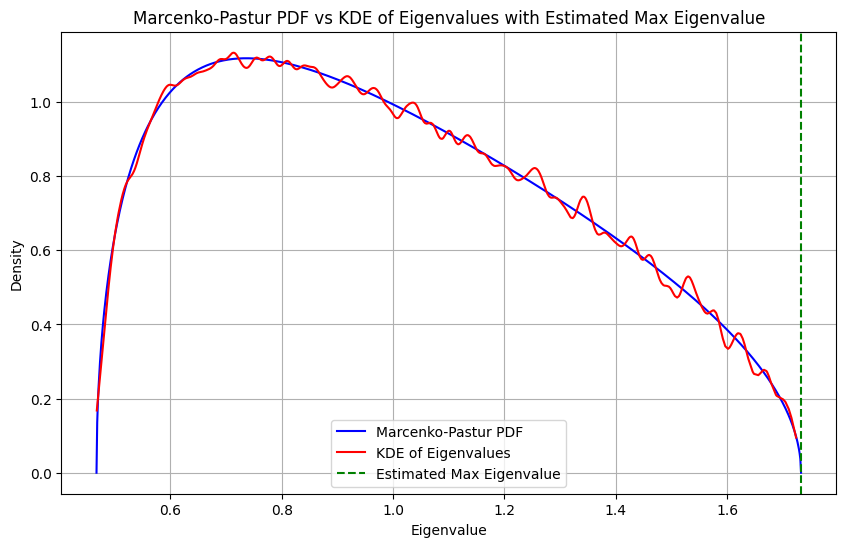

In [59]:
from scipy.optimize import minimize
from typing import Tuple

def get_max_eval(e_val:np.ndarray, q:float, b_width:float, verbose=True)-> Tuple[float, float]:
    '''
    Find the maximum eigenvalue and its corresponding bandwidth.
    '''
    def objective(var:np.ndarray, e_val, q, b_width, sample_size=1000):
        mp_pdf= get_marcenko_pastur_pdf(var[0], q, sample_size)
        kde_pdf = get_kde(e_val, b_width=b_width, x=mp_pdf.index.values)
        sse= np.sum((mp_pdf - kde_pdf) ** 2)
        return sse
    
    out=minimize(lambda *x: objective(*x), np.var(e_val), args=(e_val, q, b_width), bounds=[(1e-5, 1-1e-5),])
    var=out.x[0] if out.success else 1
    if out.success and verbose:
        print(f"Optimization successful: {out.message}, var={var:.4f}")
    e_max= var * (1 + (1/q)**0.5)**2
    return e_max, var

e_max, var = get_max_eval(np.diag(e_val), q=x.shape[0]/x.shape[1], b_width=0.01)
eig_values = np.diag(e_val)
eig_values_sorted = np.sort(eig_values)[::-1]  # 내림차순
n_ranks = np.sum(eig_values_sorted > e_max)

pdf1= get_marcenko_pastur_pdf(var=var, q=x.shape[0]/x.shape[1], sample_size=1000)
pdf2 = get_kde(np.diag(e_val), b_width=0.01)
plt.figure(figsize=(10, 6))
plt.plot(pdf1.index, pdf1, label='Marcenko-Pastur PDF', color='blue')
plt.plot(pdf2.index, pdf2, label='KDE of Eigenvalues', color='red')
plt.axvline(e_max, color='green', linestyle='--', label='Estimated Max Eigenvalue')
plt.title('Marcenko-Pastur PDF vs KDE of Eigenvalues with Estimated Max Eigenvalue')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()
plt.grid()  

print(f"Estimated maximum eigenvalue: {e_max:.4f}, Number of ranks: {n_ranks}")

2.5 Denoising

2.5.1 Constant Residual Eigenvalue Method

e_val max를 넘지못하는 eigen_value들은 모두 noise로 간주하여 trace만 유지하기 위해 모두 평균으로 치환

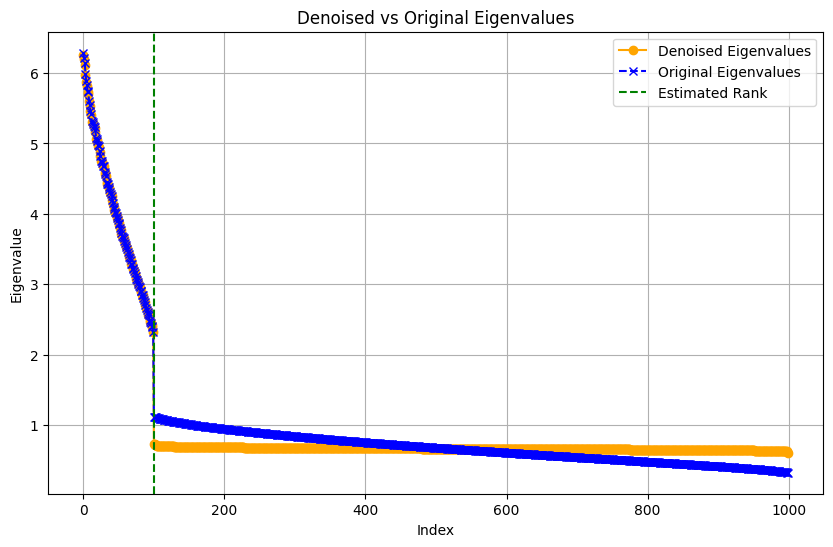

In [43]:
def get_denoised_corr_matrix(e_val:np.ndarray, e_vec:np.ndarray, n_ranks:int) -> np.ndarray:
    e_val_denoised = np.diag(e_val).copy()
    e_val_denoised[n_ranks:] = e_val_denoised[n_ranks:].sum()/(e_val_denoised.shape[0] - n_ranks) # e_val max를 넘지못하는 eigen_value들은 모두 noise로 간주
    e_val_denoised = np.diag(e_val_denoised)
    cov_matrix=e_vec @ e_val_denoised @ e_vec.T
    corr_matrix = get_corr_matrix(cov_matrix)
    return corr_matrix

corr_matrix_denoised = get_denoised_corr_matrix(e_val, e_vec, n_ranks)
e_val_denoised, e_vec_denoised = get_pca(corr_matrix_denoised)

e_val_denoised_sorted = np.sort(np.diag(e_val_denoised))[::-1]  # 내림차순
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(e_val_denoised_sorted)), e_val_denoised_sorted, label='Denoised Eigenvalues', marker='o', linestyle='-', color='orange')
plt.plot(np.arange(len(eig_values_sorted)), eig_values_sorted, label='Original Eigenvalues', marker='x', linestyle='--', color='blue')
plt.axvline(n_ranks, color='green', linestyle='--', label='Estimated Rank')
plt.title('Denoised vs Original Eigenvalues')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid()
plt.show()

2.5.2 Targeted Shrinkage

noise와 valid eigen value들을 분리하여 noise에 의한 변수간의 interaction을 제거하는 방식

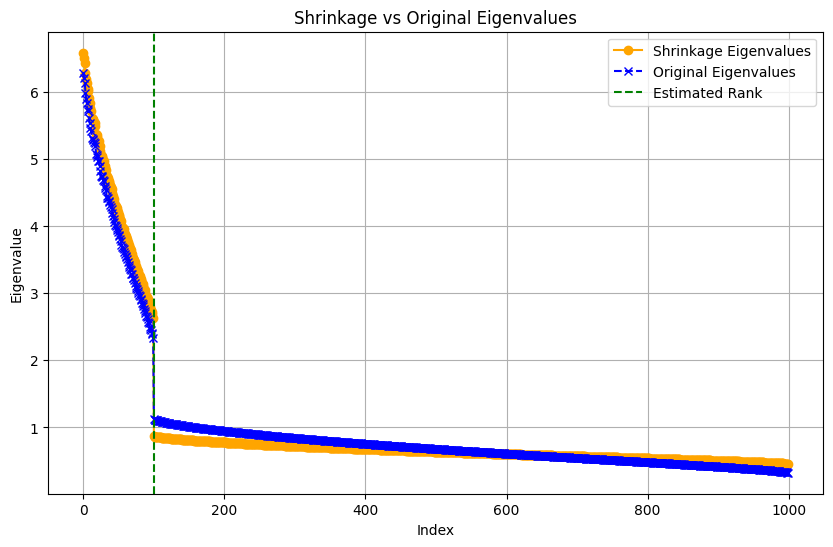

In [44]:
def get_shrinkage_corr(e_val:np.ndarray, e_vec:np.ndarray, n_ranks:int, alpha:float) -> np.ndarray:
    val_eval, val_evec=e_val[:n_ranks, :n_ranks], e_vec[:,:n_ranks]
    noise_eval, noise_evec = e_val[n_ranks:, n_ranks:], e_vec[:, n_ranks:]
    val_corr= val_evec @ val_eval @ val_evec.T
    noise_corr = noise_evec @ noise_eval @ noise_evec.T
    shrinkage_corr = val_corr+alpha*noise_corr+(1-alpha)*np.diag(np.diag(noise_corr))
    return shrinkage_corr

corr_matrix_shrinkage = get_shrinkage_corr(e_val, e_vec, n_ranks, alpha=0.5)
e_val_shrinkage, e_vec_shrinkage = get_pca(corr_matrix_shrinkage)

e_val_shrinkage_sorted = np.sort(np.diag(e_val_shrinkage))[::-1]  # 내림차순
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(e_val_shrinkage_sorted)), e_val_shrinkage_sorted, label='Shrinkage Eigenvalues', marker='o', linestyle='-', color='orange')       
plt.plot(np.arange(len(eig_values_sorted)), eig_values_sorted, label='Original Eigenvalues', marker='x', linestyle='--', color='blue')
plt.axvline(n_ranks, color='green', linestyle='--', label='Estimated Rank')
plt.title('Shrinkage vs Original Eigenvalues')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid()
plt.show()


2.6 Detoning (Exercise)

2.7 Empirical Result

Denoise를 했을때 확실히 노이즈에 강건하다는 것을 알 수 있고, shrink도 도움은 되나 denoise가 더 강력한 수단임을 알 수 있다.

In [64]:
import scipy
from sklearn.covariance import LedoitWolf

def get_block_matrix(n_blocks:int, b_size:int, b_corr:float): # S&P500의 correlation matrix와 유사하게 만들기 위함
    '''
    Generate a block diagonal matrix with specified number of blocks, block size, and block correlation.
    '''
    block=np.ones((b_size, b_size))*b_corr
    block[np.diag_indices(b_size)]=1
    corr=scipy.linalg.block_diag(*[block]*n_blocks)
    return corr

def get_true_mu_cov(n_blocks:int, b_size:int, b_corr:float) -> np.ndarray:
    '''
    Generate a true matrix with specified number of blocks, block size, block correlation, and total number of columns.
    '''
    corr=get_block_matrix(n_blocks, b_size, b_corr)
    corr=pd.DataFrame(corr)
    cols=corr.columns.tolist()
    np.random.shuffle(cols)
    corr=corr.reindex(columns=cols, index=cols)
    target_std=np.random.uniform(0.05, 0.2, size=corr.shape[0])
    cov_matrix=corr.values * np.outer(target_std, target_std)
    mu=np.random.normal(target_std, target_std, size=cov_matrix.shape[0]).reshape(-1, 1)
    return mu, cov_matrix

def get_simulated_mu_cov(mu:np.ndarray, cov_matrix:np.ndarray, n_samples:int, shrink=False) -> pd.DataFrame:
    x=np.random.multivariate_normal(mu.flatten(), cov_matrix, size=n_samples)
    mu_ret=x.mean(axis=0).reshape(-1, 1)
    if shrink:
        cov_ret=LedoitWolf().fit(x).covariance_
    else:
        cov_ret=np.cov(x, rowvar=False)
    return mu_ret, cov_ret


def get_denoised_cov_matrix(cov_matrix:np.ndarray, q:int, b_width:float, verbose=True)->np.ndarray:
    corr_matrix = get_corr_matrix(cov_matrix)
    e_val, e_vec = get_pca(corr_matrix)
    e_max, var = get_max_eval(np.diag(e_val), q=q, b_width=b_width, verbose=verbose)
    n_ranks = np.sum(np.diag(e_val) > e_max)
    corr_matrix_denoised = get_denoised_corr_matrix(e_val, e_vec, n_ranks)
    cov_matrix_denoised=corr_matrix_denoised * np.outer(np.sqrt(np.diag(cov_matrix)), np.sqrt(np.diag(cov_matrix)))
    return cov_matrix_denoised

def get_opt_portfolio(cov, mu=None):
    inv_cov = np.linalg.inv(cov)
    ones=np.ones((inv_cov.shape[0], 1))
    if mu is None: mu=ones
    w=np.dot(inv_cov, mu)
    w /= np.dot(ones.T, w)
    return w

2.7.1 Minumum Variance Portfolio

In [66]:
# Generate a true covariance matrix and mean vector for testing
from tqdm import tqdm

n_blocks, b_size, b_corr = 10, 50, 0.5
np.random.seed(0)
mu, cov_matrix = get_true_mu_cov(n_blocks, b_size, b_corr)


def get_weights(mu, cov_matrix, n_samples, b_width, shrink, min_var_oprt):
    mu_ret, cov_ret = get_simulated_mu_cov(mu, cov_matrix, n_samples, shrink=shrink)
    if min_var_oprt: mu_ret=None
    cov_ret_denoised = get_denoised_cov_matrix(cov_ret, q=n_samples/cov_ret.shape[1], b_width=b_width, verbose=False)
    w= get_opt_portfolio(cov_ret, mu_ret).flatten()
    w_d= get_opt_portfolio(cov_ret_denoised, mu_ret).flatten()
    return w, w_d


def get_rmse_portfolio_weights(mu:np.ndarray, cov_matrix:np.ndarray, n_samples:int, n_trials:int, b_width:float=0.01, shrink:bool=False, min_var_oprt:bool=True) -> pd.Series:
    w=pd.DataFrame(columns=range(cov_matrix.shape[0]), index=range(n_trials)) # [n_trials, n_assets]
    w_d=w.copy()
    for i in tqdm(range(n_trials), desc="Simulating Trials"):
        w.iloc[i], w_d.iloc[i] = get_weights(mu.copy(), cov_matrix.copy(), n_samples, b_width, shrink, min_var_oprt)

    w_ori=get_opt_portfolio(cov_matrix, None if min_var_oprt else mu)
    w_ori=np.repeat(w_ori.T, n_trials, axis=0) # [n_trials, n_assets]
    rmsd = np.sqrt(np.mean((w - w_ori).values.flatten() ** 2))
    rmsd_d = np.sqrt(np.mean((w_d - w_ori).values.flatten() ** 2))
    return pd.Series(index=['RMSE', 'RMSE_Denoised'], data=[rmsd, rmsd_d])

# Example usage
rmse_shrink= get_rmse_portfolio_weights(mu, cov_matrix, n_samples=1000, n_trials=100, b_width=0.01, shrink=True, min_var_oprt=True)
rmse_no_shrink= get_rmse_portfolio_weights(mu, cov_matrix, n_samples=1000, n_trials=100, b_width=0.01, shrink=False, min_var_oprt=True)

print("RMSE with shrinkage:", rmse_shrink)
print("RMSE without shrinkage:", rmse_no_shrink)


Simulating Trials:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Trials: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]

RMSE with shrinkage: RMSE             0.003437
RMSE_Denoised    0.001368
dtype: float64
RMSE without shrinkage: RMSE             0.004972
RMSE_Denoised    0.001145
dtype: float64


2.7.2 Maximum Sharpe Portfolio

In [67]:
rmse_shrink= get_rmse_portfolio_weights(mu, cov_matrix, n_samples=1000, n_trials=100, b_width=0.01, shrink=True, min_var_oprt=False)
rmse_no_shrink= get_rmse_portfolio_weights(mu, cov_matrix, n_samples=1000, n_trials=100, b_width=0.01, shrink=False, min_var_oprt=False)

print("RMSE with shrinkage (Max Sharpe):", rmse_shrink)
print("RMSE without shrinkage (Max Sharpe):", rmse_no_shrink)

Simulating Trials: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]

RMSE with shrinkage (Max Sharpe): RMSE             0.080644
RMSE_Denoised    0.014062
dtype: float64
RMSE without shrinkage (Max Sharpe): RMSE             0.896951
RMSE_Denoised    0.014715
dtype: float64
